# Image analysis with the kluster.ai API

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kluster-ai/klusterai-cookbook/blob/main/examples/sentiment-analysis-api.ipynb)

AI models can be used to perform image analysis tasks, in which you feed the model an image and request it to extract meaningful information.

This tutorial runs through a notebook where you'll learn how to use the <a href="https://kluster.ai/" target="_blank">kluster.ai</a> batch API to run image analysis on different images using Gemma 3 27B, Qwen 2.5 7B, Llama 4 Maverick 17B 128E and Llama 4 Scout 17B 16E.

The example uses four separate images. For each image, we will ask the models to fetch a specific feature and compare how they respond:

- A <a href="https://github.com/kluster-ai/klusterai-cookbook/blob/main/images/balls-image.jpeg?raw=true" target="_blank">Newton's cradle</a>, we will ask what the device's name is and how many balls are in the image (5)
- <a href="https://github.com/kluster-ai/klusterai-cookbook/blob/main/images/eggs-image.jpeg?raw=true" target="_blank">Eggs</a> of different colors, we will ask how many total eggs and per color (10 total, 8 brown and 2 white)
- <a href="https://github.com/kluster-ai/klusterai-cookbook/blob/main/images/parking-image.jpeg?raw=true" target="_blank">Alien-only parking sign</a>, we will ask to interpret the sign (only aliens can park, funny reference)
- <a href="https://github.com/kluster-ai/klusterai-cookbook/blob/main/images/text-typo-image.jpeg?raw=true" target="_blank">Handwritten note with a typo</a>, we will ask what the text in the image is and to find a typo ("I LOVE PROGRAMING", "I love programing" missing an "m" in both instances)

You can adapt this example by using your own images or requests. With this approach, you can effortlessly process images of any scale, big or small, and obtain image analysis powered by a state-of-the-art language model.

## Prerequisites

Before getting started, ensure you have the following:

- **A kluster.ai account** - sign up on the <a href="https://platform.kluster.ai/signup" target="_blank">kluster.ai platform</a> if you don't have one
- **A kluster.ai API key** - after signing in, go to the <a href="https://platform.kluster.ai/apikeys" target="_blank">**API Keys**</a> section and create a new key. For detailed instructions, check out the <a href="/get-started/get-api-key/" target="_blank">Get an API key</a> guide

## Setup

In this notebook, we'll use Python's `getpass` module to input the key safely. After execution, please provide your unique kluster.ai API key (ensure no spaces).

In [1]:
from getpass import getpass

api_key = getpass("Enter your kluster.ai API key: ")

Enter your kluster.ai API key:  ········


Next, ensure you've installed OpenAI Python library:

In [2]:
%pip install -q openai

Note: you may need to restart the kernel to use updated packages.


With the OpenAI Python library installed, we import the necessary dependencies for the tutorial:

In [3]:
from openai import OpenAI

import pandas as pd
import time
import json
import os
import re
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
from collections import defaultdict
from io import BytesIO

Then, initialize the `client` by pointing it to the kluster.ai endpoint and passing your API key.

In [4]:
# Set up the client
client = OpenAI(
    base_url="https://api.kluster.ai/v1",
    api_key=api_key,
)

## Get the data

There are two main ways to proceed when working with images:

1. You can provide the raw image file as a URL from the source, for example, GitHub
2. You can provide Base64 encoded. These are typically represented with a blob of text, which starts with `data:image/png;base64,ENCODING_DATA_HERE...`

With both methodologies, image data needs to be provided as an object in the content array with the following format:

```
...
{"type": "image_url", "image_url": {"url": IMAGE_DATA}}
...
```

Just replace `IMAGE_DATA` with either the URL with the raw image file or the Base64 encoded image. This tutorial uses the URL of the images uploaded to GitHub:


In [5]:
base_url = (
    "https://github.com/kluster-ai/klusterai-cookbook/blob/main/images/IMAGE_NAME?raw=true"
)

# Newton's cradle image
# Expected answer: Newton's cradle, 5 balls
image1 = "balls-image.jpeg"
image1_url = base_url.replace("IMAGE_NAME", image1)
print(image1_url)


# Eggs
# Expected answer: 10 eggs, 8 brown and 2 white
image2 = "eggs-image.jpeg"
image2_url = base_url.replace("IMAGE_NAME", image2)
print(image2_url)

# Parking sign
# Expected answer: Parking only allowed for Aliens (funny)
image3 = "parking-image.jpeg"
image3_url = base_url.replace("IMAGE_NAME", image3)
print(image3_url)

# Text
# Expected answer: I love programming in both all caps and regular
image4 = "text-typo-image.jpeg"
image4_url = base_url.replace("IMAGE_NAME", image4)
print(image4_url)


images = [image1, image2, image3, image4]

https://github.com/kluster-ai/klusterai-cookbook/blob/main/images/balls-image.jpeg?raw=true
https://github.com/kluster-ai/klusterai-cookbook/blob/main/images/eggs-image.jpeg?raw=true
https://github.com/kluster-ai/klusterai-cookbook/blob/main/images/parking-image.jpeg?raw=true
https://github.com/kluster-ai/klusterai-cookbook/blob/main/images/text-typo-image.jpeg?raw=true


## Perform batch inference

To execute the batch inference job, we'll take the following steps:

1. **Create the batch job file** - we'll generate a JSON lines file with the desired requests to be processed by the model
2. **Upload the batch job file** - once it is ready, we'll upload it to the <a href="https://platform.kluster.ai/signup" target="_blank">kluster.ai platform</a> using the API, where it will be processed. We'll receive a unique ID associated with our file
3. **Start the batch job** - after the file is uploaded, we'll initiate the job to process the uploaded data, using the file ID obtained before
4. **Monitor job progress** - (optional) track the status of the batch job to ensure it has been successfully completed
5. **Retrieve results** - once the job has completed execution, we can access and process the resultant data

This notebook is prepared for you to follow along. Run the cells below to watch it all come together.

### Create the batch input file

This example uses two models more oriented to image vision/analysis: `google/gemma-3-27b-it`, `Qwen/Qwen2.5-VL-7B-Instruct`, `meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8` and `meta-llama/Llama-4-Scout-17B-16E-Instruct`. Other models might not support providing images.

In addition, please refer to the <a href="/get-started/models/#model-comparison-table" target="_blank">Supported models</a> section for a list of the models we support.

The following snippets prepare the JSONL file, where each line represents a different request. Note that each separate batch request can have its own model. Also, we are using a temperature of `0.5` but feel free to change it and play around with the different outcomes.


In [6]:
# Prompt based on image
SYSTEM_PROMPTS = {
    "balls-image.jpeg": """
    You are a helpful assistant that analyzes image content and provide short answers.
    Tell me the device depicted in the image, and how many balls it has.
    """,
    "eggs-image.jpeg": """
    You are a helpful assistant that analyzes image content and provide short answers.
    Count how many eggs are in total, and how many brown and white eggs separately.
    """,
    "parking-image.jpeg": """
    You are a helpful assistant that analyzes image content and provide short answers.
    Tell me what you see in the image, anything interesting?.
    """,
    "text-typo-image.jpeg": """
    You are a helpful assistant that can extract text from images and provide short answers.
    Tell me the text written in the image, find any typos if any.
    """,
}

# Models
models = {
    "Gemma3-27B": "google/gemma-3-27b-it",
    "Qwen2.5-7B": "Qwen/Qwen2.5-VL-7B-Instruct",
    "Llama4-Maverick-17B": "meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
    "Llama4-Scout-17B": "meta-llama/Llama-4-Scout-17B-16E-Instruct"
}

# Ensure the directory exists
os.makedirs("image_analysis", exist_ok=True)

# Create the batch job file with the prompt and content for the model and the image
def create_batch_file(model, image):
    image_url = base_url.replace("IMAGE_NAME", image)
    request = {
        "custom_id": f"image-{image}-{model}-analysis",
        "method": "POST",
        "url": "/v1/chat/completions",
        "body": {
            "model": models[model],
            "temperature": 0.5,
            "messages": [
                {"role": "system", "content": SYSTEM_PROMPTS[image]},
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image_url",
                            "image_url": {"url": image_url},
                        }
                    ],
                },
            ],
        },
    }

    return request

# Save file
def save_batch_file(batch_requests, model):
    filename = f"image_analysis/batch_job_{model}_request.jsonl"
    with open(filename, "w") as file:
        for request in batch_requests:
            file.write(json.dumps(request) + "\n")
    return filename


Let's run the functions we've defined before:

In [7]:
filenames = []

for image in images:
    batch_requests = []
    for model in models:
        batch_request = create_batch_file(model, image)
        batch_requests.append(batch_request)
    filename = save_batch_file(batch_requests, image)
    filenames.append(filename)
    print(filename)

image_analysis/batch_job_balls-image.jpeg_request.jsonl
image_analysis/batch_job_eggs-image.jpeg_request.jsonl
image_analysis/batch_job_parking-image.jpeg_request.jsonl
image_analysis/batch_job_text-typo-image.jpeg_request.jsonl


Next, we can preview what one of the batch job files looks like:

In [8]:
!head -n 1 image_analysis/batch_job_balls-image.jpeg_request.jsonl

{"custom_id": "image-balls-image.jpeg-Gemma3-27B-analysis", "method": "POST", "url": "/v1/chat/completions", "body": {"model": "google/gemma-3-27b-it", "temperature": 0.5, "messages": [{"role": "system", "content": "\n    You are a helpful assistant that analyzes image content and provide short answers.\n    Tell me the device depicted in the image, and how many balls it has.\n    "}, {"role": "user", "content": [{"type": "image_url", "image_url": {"url": "https://github.com/kluster-ai/klusterai-cookbook/blob/main/images/balls-image.jpeg?raw=true"}}]}]}}


### Upload inference file to kluster.ai

Now that we've prepared our input files, it's time to upload them to the kluster.ai platform. To do so, you can use the `files.create` endpoint of the client, where the purpose is set to `batch`. This will return the file ID, which we need to log for the next steps. We will repeat the process for each batch file created.

In [9]:
def upload_batch_file(data_dir):
  print(f"Creating request for {data_dir}")
  
  with open(data_dir, 'rb') as file:
    upload_response = client.files.create(
    file=file,
    purpose="batch"
  )

  # Print job ID
  file_id = upload_response.id
  print(f"File uploaded successfully. File ID: {file_id}")

  return upload_response

In [10]:
batch_files = []

# Loop through all .jsonl files in the data folder
for data_dir in filenames:
    print(f"Uploading file {data_dir}")
    job = upload_batch_file(data_dir)
    batch_files.append(job)

Uploading file image_analysis/batch_job_balls-image.jpeg_request.jsonl
Creating request for image_analysis/batch_job_balls-image.jpeg_request.jsonl
File uploaded successfully. File ID: 67f54c0e7972d8f7ead583e2
Uploading file image_analysis/batch_job_eggs-image.jpeg_request.jsonl
Creating request for image_analysis/batch_job_eggs-image.jpeg_request.jsonl
File uploaded successfully. File ID: 67f54c0e0c563cd229eab4e9
Uploading file image_analysis/batch_job_parking-image.jpeg_request.jsonl
Creating request for image_analysis/batch_job_parking-image.jpeg_request.jsonl
File uploaded successfully. File ID: 67f54c0f15bf67f662b74653
Uploading file image_analysis/batch_job_text-typo-image.jpeg_request.jsonl
Creating request for image_analysis/batch_job_text-typo-image.jpeg_request.jsonl
File uploaded successfully. File ID: 67f54c0fd056b693f12d7100


All files are now uploaded, and we can proceed with creating the batch jobs.

### Start the job

Once all the files have been successfully uploaded, we're ready to start (create) the batch jobs by providing the file ID of each file, which we got in the previous step. To start each job, we use the `batches.create` method, for which we need to set the endpoint to `/v1/chat/completions`. This will return each batch job details, with each ID.

In [11]:
# Create batch job with completions endpoint
def create_batch_job(file_id):
  batch_job = client.batches.create(
    input_file_id=file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h"
  )

  print(f"Batch job created with ID {batch_job.id}")
  return batch_job

In [12]:
batch_jobs = []

# Loop through all batch files ID and start each job
for batch_file in batch_files:
    print(f"Creating batch job for file ID {batch_file.id}")
    batch_job = create_batch_job(batch_file.id)
    batch_jobs.append(batch_job)

Creating batch job for file ID 67f54c0e7972d8f7ead583e2
Batch job created with ID 67f54c13917b9e5fb870937f
Creating batch job for file ID 67f54c0e0c563cd229eab4e9
Batch job created with ID 67f54c147972d8f7ead5842c
Creating batch job for file ID 67f54c0f15bf67f662b74653
Batch job created with ID 67f54c140c563cd229eab53c
Creating batch job for file ID 67f54c0fd056b693f12d7100
Batch job created with ID 67f54c1415bf67f662b746af


All requests are queued to be processed.

### Check job progress

Now that your batch jobs have been created, you can track their progress.

To monitor the job's progress, we can use the `batches.retrieve` method and pass the batch job ID. The response contains a `status` field that tells whether it is completed or not and the subsequent status of each job separately. We can repeat this process for every batch job ID we got in the previous step.

The following snippet checks the status of all batch jobs every 10 seconds until the entire batch is completed.

In [13]:
def monitor_batch_jobs(batch_jobs):
    all_completed = False

    # Loop until all jobs are completed
    while not all_completed:
        all_completed = True
        output_lines = []

        # Loop through all batch jobs
        for job in batch_jobs:
            updated_job = client.batches.retrieve(job.id)
            status = updated_job.status

            # If job is completed
            if status == "completed":
                output_lines.append("Job completed!")
            # If job failed, cancelled or expired
            elif status in ["failed", "cancelled", "expired"]:
                output_lines.append(f"Job ended with status: {status}")
                break
            # If job is ongoing
            else:
                all_completed = False
                completed = updated_job.request_counts.completed
                total = updated_job.request_counts.total
                output_lines.append(
                    f"Job status: {status} - Progress: {completed}/{total}"
                )

        # Clear terminal
        clear_output(wait=True)
        for line in output_lines:
            display(line)

        # Check every 10 seconds
        if not all_completed:
            time.sleep(10)


In [14]:
monitor_batch_jobs(batch_jobs)

'Job completed!'

'Job completed!'

'Job completed!'

'Job completed!'

## Get the results

With all jobs completed, we'll retrieve the results and review the responses generated for each request. The results are parsed. To fetch the results from the platform, you must retrieve the `output_file_id` from the batch job and then use the `files.content` endpoint, providing that specific file ID. We will repeat this for every single batch job id. Note that the job status must be `completed` to retrieve the results!

In [15]:
#Parse results as a JSON object
def parse_json_objects(data_string):
  if isinstance(data_string, bytes):
    data_string = data_string.decode('utf-8')

  json_strings = data_string.strip().split('\n')
  json_objects = []

  for json_str in json_strings:
    try:
      json_obj = json.loads(json_str)
      json_objects.append(json_obj)
    except json.JSONDecodeError as e:
      print(f"Error parsing JSON: {e}")

  return json_objects

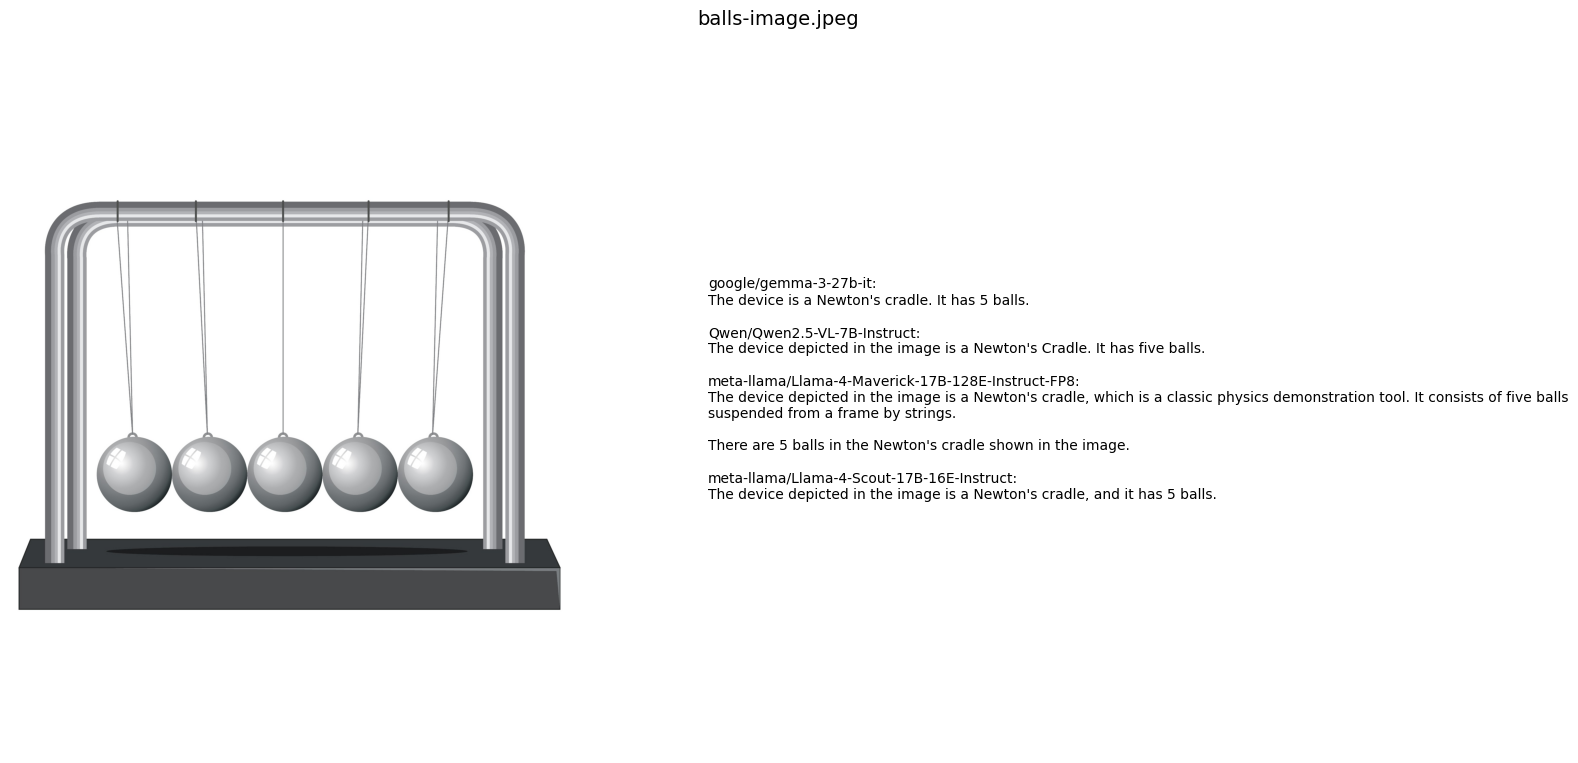

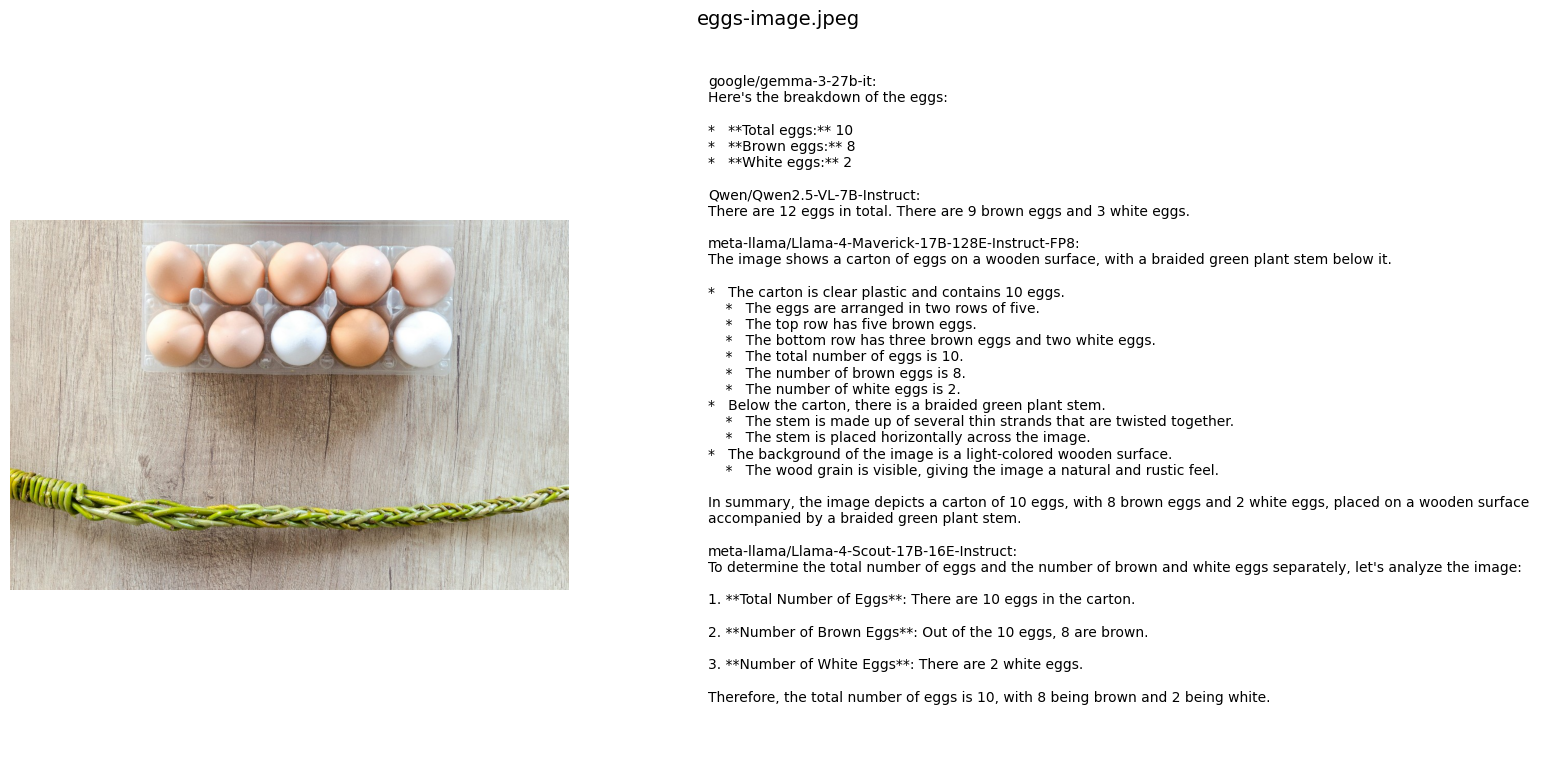

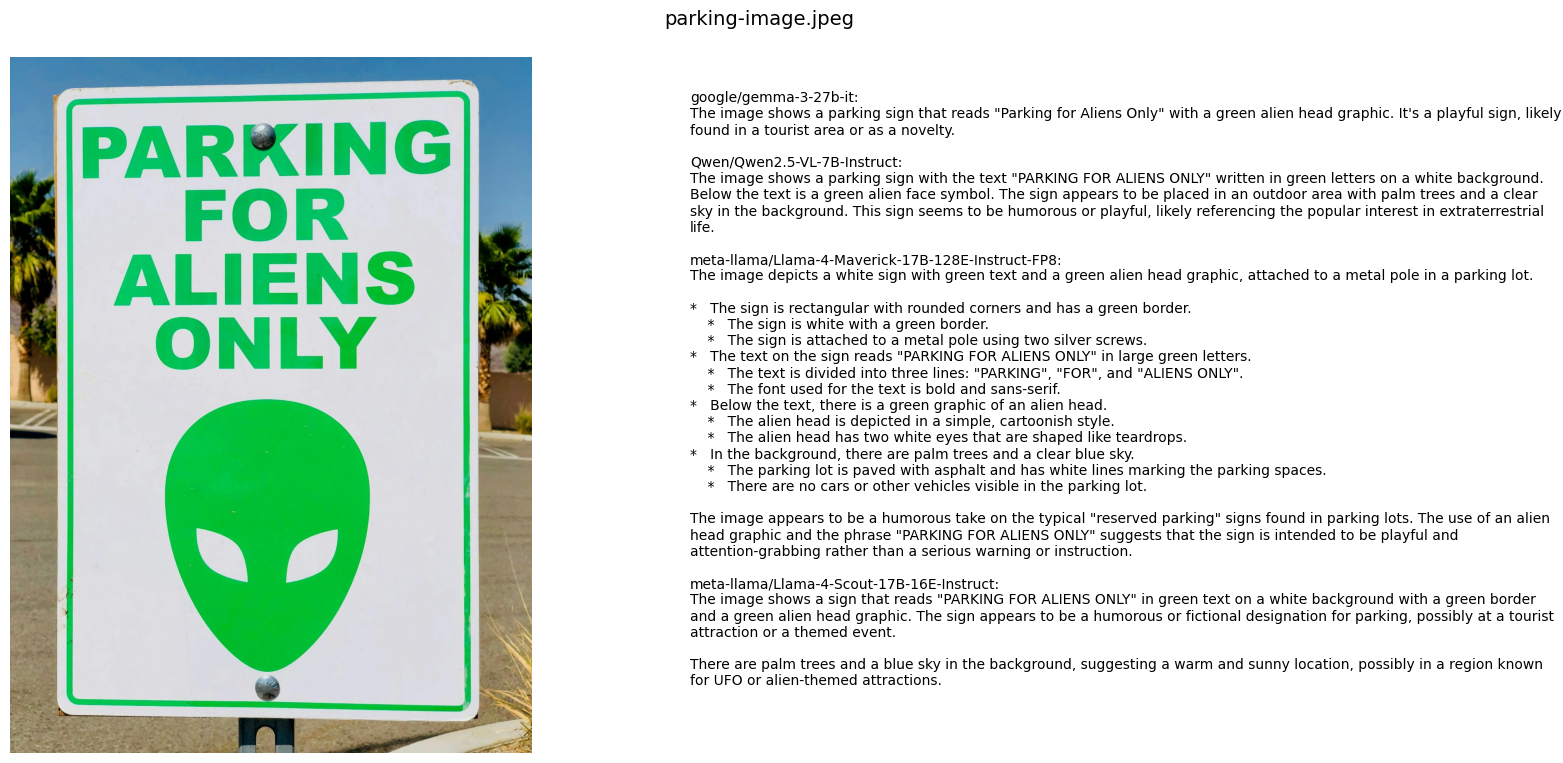

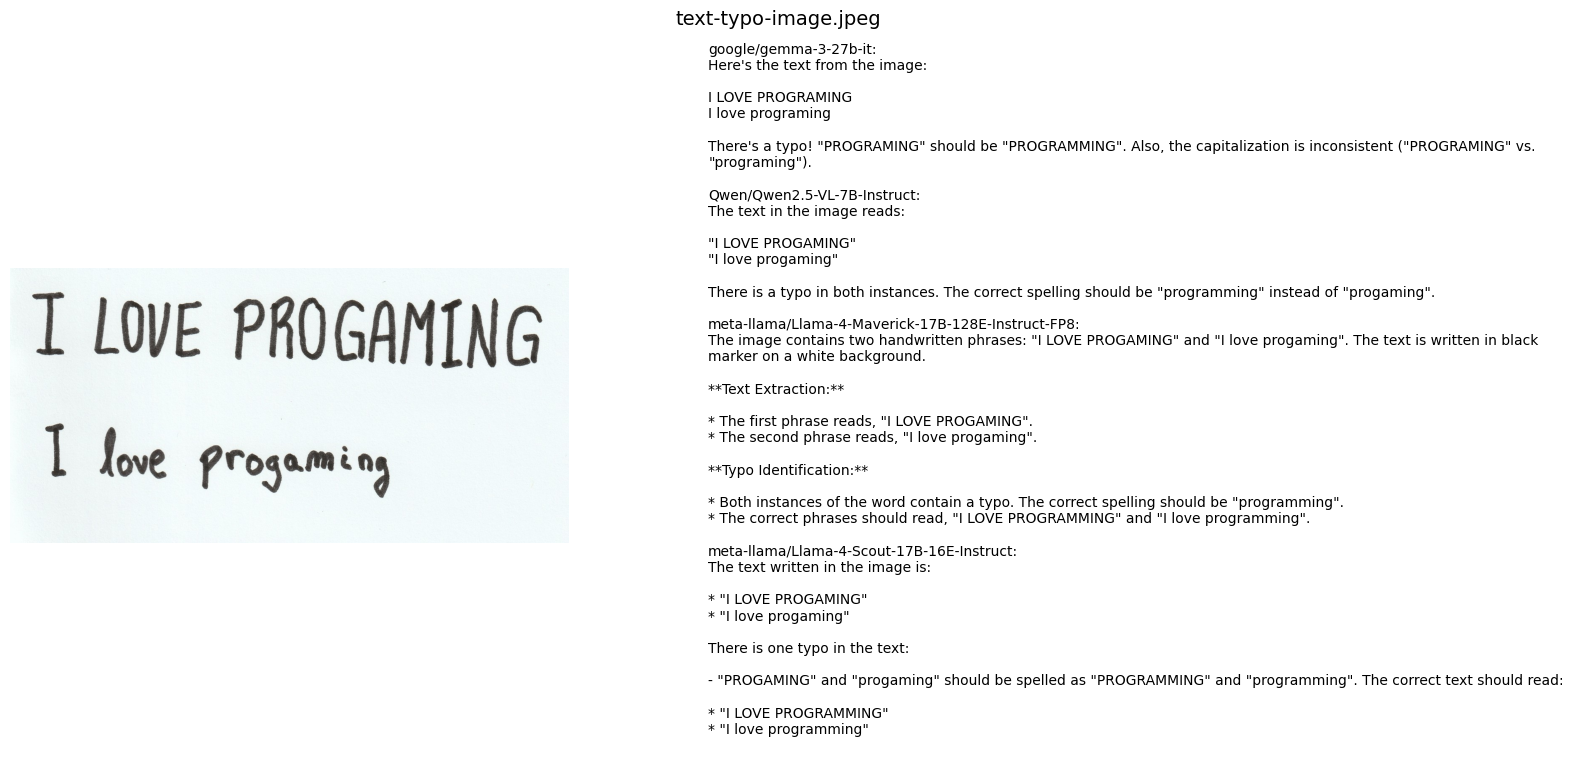

In [16]:
# Group all responses by image name
results_by_image = defaultdict(list)

# Go through all batch jobs, providing the output file ID
for batch_job in batch_jobs:
  job_status = client.batches.retrieve(batch_job.id)
  result_file_id = job_status.output_file_id
  result = client.files.content(result_file_id).content
  results = parse_json_objects(result)

  # For each, print the result
  for res in results:
    inference_id = res['custom_id']
      
    # Extract image with regex (ending in .jpeg)
    match = re.search(r'image-(.*?\.jpeg)', inference_id)
    image_name = match.group(1) if match else "unknown.jpeg"
    
    # Extract response      
    model = res['response']['body']['model']
    content  = res['response']['body']['choices'][0]['message']['content'].strip()

    results_by_image[image_name].append((model, content))

# Plot results for each image
for image_name, model_outputs in results_by_image.items():
    image_url = base_url.replace("IMAGE_NAME", image_name)

    # Load image
    response = requests.get(image_url)
    img = mpimg.imread(BytesIO(response.content), format='jpeg')

    # Build formatted model output string
    formatted_text = ""
    for model, output in model_outputs:
        formatted_text += f"{model}:\n{output}\n\n"

    # Create side-by-side layout
    fig, ax = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1.5]})
    fig.subplots_adjust(left=0.02, right=0.98, top=0.92, bottom=0.05, wspace=0.2)
    fig.suptitle(image_name, fontsize=14)

    # --- Left: Image ---
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[0].set_anchor('C')  # Vertical center

    # --- Right: Model output ---
    ax[1].axis('off')
    ax[1].set_anchor('C')  # Vertical center
    ax[1].text(0, 0.5, formatted_text, fontsize=10, va='center', wrap=True)

    plt.show()


## Summary

This tutorial used the chat completion endpoint to image analysis on multiple images using kluster.ai batch API. This particular example uploaded four specific images:

- A <a href="https://github.com/kluster-ai/klusterai-cookbook/blob/main/images/balls-image.jpeg?raw=true" target="_blank">Newton's cradle</a>, we asked what the device's name is and how many balls were in the image (5):
   - All models responded correctly ✅
- <a href="https://github.com/kluster-ai/klusterai-cookbook/blob/main/images/eggs-image.jpeg?raw=true" target="_blank">Eggs</a> of different colors, we asked how many total eggs and per color (10 total, 8 brown and 2 white):
   - Gemma 3 27B was able to identify all 10 eggs correctly, counting 8 brown and 2 white ✅ (although sometimes it provided a 7/3 split between white and brown eggs)
   - Qwen 2.5 7B counted 12 eggs, identifying 9 white and 3 brown ❌
   - Both Llama 4 models were able to identify all 10 eggs properly, counting 8 brown and 2 white ✅
- <a href="https://github.com/kluster-ai/klusterai-cookbook/blob/main/images/parking-image.jpeg?raw=true" target="_blank">Aliens only parking sign</a>, we asked to interpret the sign (only aliens can park, funny reference):
   - All models identified the sign appropriately ✅
- <a href="https://github.com/kluster-ai/klusterai-cookbook/blob/main/images/text-typo-image.jpeg?raw=true" target="_blank">Hand written note with a typo</a>, we asked what the text in the image is and to find a typo if any ("I LOVE PROGRAMING", "I love programing" missing an "m" in both instances):
   - All models responded correctly ✅
  

All models were also tested with a musical score by asking them to identify the sequence of notes. However, none of the models were able to correctly recognize the musical notes, so this test was not included in the final notebook.

To submit a batch job, we've:

1. Created the JSONL file, where each file line represented a separate request. We provided the images as URLs from GitHub
2. Submitted the file to the platform
3. Started the batch job, and monitored its progress
4. Once completed, we fetched the results

All of this using the OpenAI Python library and API, no changes needed!

Kluster.ai's batch API empowers you to scale your workflows seamlessly, making it an invaluable tool for processing extensive datasets. As the next steps, feel free to create your own dataset, or expand on top of this existing example. Good luck!